## 1 - Introduction
This notebook is for clean the dataset downloaded from Lending Club website.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time
from scipy.stats import shapiro
import statsmodels.api as sm
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## 2 - PreProcessing

The dataset was download from [Lending Club](https://www.lendingclub.com/statistics/additional-statistics?). It contains information from 2015 to 2019. 

**Data manipulation**: 

    - Deal with missing value 
    - check each feature
        - observe distribution (normality for particular features)
        - Remove outliner (standard deviation)



In [2]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'data_col_pickup.csv', low_memory=True, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'issue_year'] )
end = time.time()
print('It takes  ' + str(end-start) +' sec to read the data')

It takes  58.54715371131897 sec to read the data


In [3]:
df.head()

,issue_d,earliest_cr_line,last_pymnt_d,issue_year,int_rate,revol_util,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,loan_amnt,funded_amnt,installment,annual_inc,int_rate.1,dti,revol_bal,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,total_pymnt,recoveries
0,2015-12-01,2005-01-01,2018-08-01,2015-01-01,13.99,87.4,60 months,C,< 1 year,RENT,Source Verified,Fully Paid,credit_card,OH,21000.0,21000.0,488.53,52000.0,13.99,14.47,20374.0,0.0,5.0,0.0,684.0,680.0,27285.807861,0.0
1,2015-12-01,1997-06-01,2020-01-01,2015-01-01,12.88,24.1,60 months,C,10+ years,MORTGAGE,Not Verified,Current,debt_consolidation,MO,16800.0,16800.0,381.23,118000.0,12.88,34.29,7849.0,0.0,11.0,1.0,684.0,680.0,18650.220000,0.0
2,2015-12-01,1995-04-01,2020-01-01,2015-01-01,12.88,32.7,60 months,C,6 years,MORTGAGE,Not Verified,Current,debt_consolidation,SC,22400.0,22400.0,508.30,95000.0,12.88,22.98,13028.0,0.0,16.0,0.0,714.0,710.0,24866.630000,0.0
3,2015-12-01,2002-04-01,2018-08-01,2015-01-01,6.49,34.5,36 months,A,6 years,RENT,Not Verified,Fully Paid,credit_card,PA,10000.0,10000.0,306.45,85000.0,6.49,13.07,10464.0,0.0,14.0,1.0,689.0,685.0,10998.971575,0.0
4,2015-12-01,1994-11-01,2017-04-01,2015-01-01,11.48,39.1,36 months,B,10+ years,MORTGAGE,Not Verified,Fully Paid,credit_card,RI,8000.0,8000.0,263.74,42000.0,11.48,34.80,7034.0,0.0,8.0,0.0,704.0,700.0,8939.580503,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2307030 entries, 0 to 2312461
Data columns (total 28 columns):
issue_d                datetime64[ns]
earliest_cr_line       datetime64[ns]
last_pymnt_d           datetime64[ns]
issue_year             datetime64[ns]
int_rate               float64
revol_util             float64
term                   object
grade                  object
emp_length             object
home_ownership         object
verification_status    object
loan_status            object
purpose                object
addr_state             object
loan_amnt              float64
funded_amnt            float64
installment            float64
annual_inc             float64
int_rate.1             float64
dti                    float64
revol_bal              float64
delinq_2yrs            float64
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
total_pymnt            float64
recoveries             float64

In [5]:
# check columns
print(sorted(df.columns))

['addr_state', 'annual_inc', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'installment', 'int_rate', 'int_rate.1', 'issue_d', 'issue_year', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'recoveries', 'revol_bal', 'revol_util', 'term', 'total_pymnt', 'verification_status']


In [6]:
df.drop(['int_rate.1'], axis=1, inplace=True)

In [7]:
print("Dataset has " + str(df.shape[0]) + " rows" +' and ' + str(df.shape[1]) + ' columns')

Dataset has 2307030 rows and 27 columns


## 3- Pre-processing 

- Set loan status as target


### Target

In [8]:
df['loan_status'].value_counts(dropna=False)

Current               1017797
Fully Paid             994572
Charged Off            256642
Late (31-120 days)      22597
In Grace Period         10744
Late (16-30 days)        4619
Default                    48
Issued                     11
Name: loan_status, dtype: int64

In [9]:
# only select either 'Fully Paid' or 'Charged Off' for Target
df = df.loc[df['loan_status'].isin(["Fully Paid", "Charged Off"])]

In [10]:
# check missing value
df['loan_status'].isnull().sum()

0

In [11]:
# check distribution for binary classification
df['loan_status'].value_counts(normalize=True)

Fully Paid     0.794886
Charged Off    0.205114
Name: loan_status, dtype: float64

It looks like the target is imbalance

Next, tag the 'Fully Paid' to 0; 'Charged Off' to 1

In [12]:
# fully paid: 0, charged off:1
df['target'] = df['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1)
df['target'].value_counts(normalize=True) 

0    0.794886
1    0.205114
Name: target, dtype: float64

### Calculate loan period
calcluate the time period of the loan for each borrower
- `last payment date` minus `loan issue date`

In [13]:
df['loan_period'] = (df['last_pymnt_d'] - df['issue_d']) / np.timedelta64(1, 'M')

In [14]:
# remove loan_period = 0
df = df[df['loan_period']!=0]

(0, 0.1)

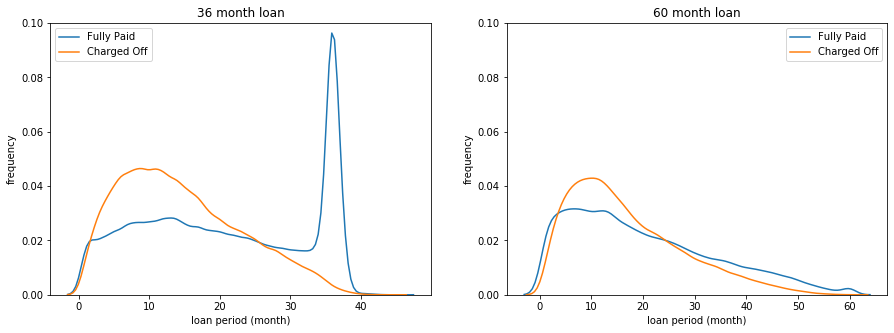

In [15]:
# compare loan period for 36 month vs 60 month loan
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,5))

sns.distplot(df[(df['target']==0) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50, rug=False, label = 'Fully Paid', ax=ax1)
sns.distplot(df[(df['target']==1) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Charged Off', ax=ax1)

ax1.set_title('36 month loan')
ax1.set_xlabel('loan period (month)')
ax1.set_ylabel('frequency')
ax1.set_ylim([0, 0.1])

sns.distplot(df[(df['target']==0) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Fully Paid', ax=ax2)
sns.distplot(df[(df['target']==1) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Charged Off', ax=ax2)

ax2.set_title('60 month loan')
ax2.set_xlabel('loan period (month)')
ax2.set_ylabel('frequency')
ax2.set_ylim([0, 0.1])

For borrowers who have 36 month loan, they tend to pay off at the very end of their loans.

### List description for each column

In [17]:
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description_pick = df_description[df_description['LoanStatNew'].isin(df.columns)]
df_description_pick.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
21,fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
22,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
23,funded_amnt,The total amount committed to that loan at that point in time.
25,grade,LC assigned loan grade


### Deal with missing value
- since only two columns have missing values (<10%), I just remove the row containing missing values
- assuming these missing values are random as the non-missing value (need to check?)

In [18]:
# show missing data
df.isnull().sum()[df.isnull().sum() >0]/len(df)*100

emp_length    6.804003
dti           0.068367
dtype: float64

In [19]:
#Drop the row where at least one element is missing.
df.dropna(axis=0, inplace=True)

In [20]:
# show missing data
df.isnull().sum()[df.isnull().sum() >0]/len(df)*100

Series([], dtype: float64)

In [21]:
df_ml = df.copy()

In [22]:
df_ml.shape

(1154553, 29)

### Remove Outlier
- Remove outliers from numerical columns
- Because most of the numerical feature is not a normal distribution, we can use IQR to remove the outlier

In [23]:
col_num = df.select_dtypes(include=np.number).columns.tolist()
col_num.remove('target')
col_num.remove('loan_period')

In [24]:
# pick up column to remove outliner
col_num

['int_rate',
 'revol_util',
 'loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'total_pymnt',
 'recoveries']

In [25]:
def remove_outlier_IQR(df, col_name):
    '''
    remove outliner (above/below 1.5*IQR)
    input: original dataframe, column name
    output: new dataframe (without outliner)
    '''
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return df[~((df[col_name] > upper_bound) | (df[col_name] < lower_bound))]#.any(axis=1)]

### Look at indifivual feature

Examine each feature individually, and do the following:

- View summary statistics and visualize the data against the loan status.
- Modify the feature to make it useful for modeling.
- Drop the feature, if it is not useful to predict the loan status.

In [26]:
# make general plots to examine each feature
def plot_num(df, col_name, full_name):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    # seperate dataframe: 'fully paid' vs 'charged off'
    df_fp = df.loc[df['loan_status'] == 'Fully Paid']
    df_co = df.loc[df['loan_status'] == 'Charged Off']
    
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,4))
    # plot1: counts distribution of the variable
    sns.distplot(df_fp[col_name], hist=False, rug=False, label = 'Fully Paid', ax=ax1)
    sns.distplot(df_co[col_name], hist=False, rug=False, label = 'Charged Off', ax=ax1)
    
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    #plt.show()
          
    # plot2: box plot of the variable grouped by loan_status
    sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('')
    ax2.set_title(full_name)
  
    plt.tight_layout()

In [27]:
def plot_cat(df, col_name, full_name, height=5):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,height))
    # plot1: counts distribution of the variable

    sns.countplot(y=col_name, data = df, order = df[col_name].value_counts().index, \
                  color = 'steelblue', ax=ax1)
    ax1.set_xlabel('Count')
    ax1.set_ylabel('')
    ax1.set_title(full_name)

    #plt.show()
          
    # plot2: box plot of the variable grouped by loan_status
    charged_off_rate = df.groupby(col_name)['loan_status']\
    .value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

    sns.barplot(x=charged_off_rate.values, y=charged_off_rate.index, orient = "h", \
                order=charged_off_rate.index, color = 'steelblue',ax=ax2)

    ax2.set_xlabel('Charged off rate')
    ax2.set_ylabel('')
    ax2.set_title(full_name)

    plt.tight_layout()

In [28]:
# function to check normality
# Shapiro-Wilk Test

def Shapiro_Wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

#### datetime type

#### 1) `issue_d`
- The month which the loan was funded


In [29]:
df['issue_d'].describe()

count                 1154553
unique                     60
top       2016-03-01 00:00:00
freq                    52375
first     2015-01-01 00:00:00
last      2019-12-01 00:00:00
Name: issue_d, dtype: object

#### 2) `earliest_cr_line`
- The month the borrower's earliest reported credit line was opened

In [30]:
df['earliest_cr_line'].describe()

count                 1154553
unique                    727
top       2004-09-01 00:00:00
freq                     8847
first     1933-03-01 00:00:00
last      2016-10-01 00:00:00
Name: earliest_cr_line, dtype: object

#### 3) `last_pymnt_d`
- Last month payment was received

In [31]:
df['last_pymnt_d'].describe()

count                 1154553
unique                     61
top       2019-07-01 00:00:00
freq                    36625
first     2015-02-01 00:00:00
last      2020-02-01 00:00:00
Name: last_pymnt_d, dtype: object

#### 4) `issue_year`


In [32]:
df['issue_year'].describe()

count                 1154553
unique                      5
top       2016-01-01 00:00:00
freq                   368122
first     2015-01-01 00:00:00
last      2019-01-01 00:00:00
Name: issue_year, dtype: object

#### Numerical variable

For numerical variable, check normality using 

#### 5) `int_rate`
- Interest Rate on the loan

In [33]:
df['int_rate'].describe()

count    1.154553e+06
mean     1.292402e+01
std      4.934793e+00
min      5.310000e+00
25%      9.170000e+00
50%      1.229000e+01
75%      1.561000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

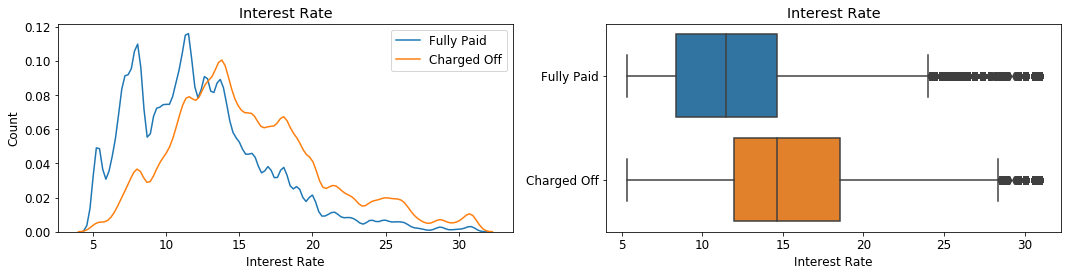

In [34]:
plot_num(df, 'int_rate', 'Interest Rate')

after removing outlier:

In [35]:
df_int_rate = df[['int_rate', 'loan_status']].copy()

In [36]:
len(df['int_rate'])

1154553

In [37]:
df_int_rate = remove_outlier_IQR(df_int_rate, 'int_rate')

In [38]:
len(df_int_rate)

1125066

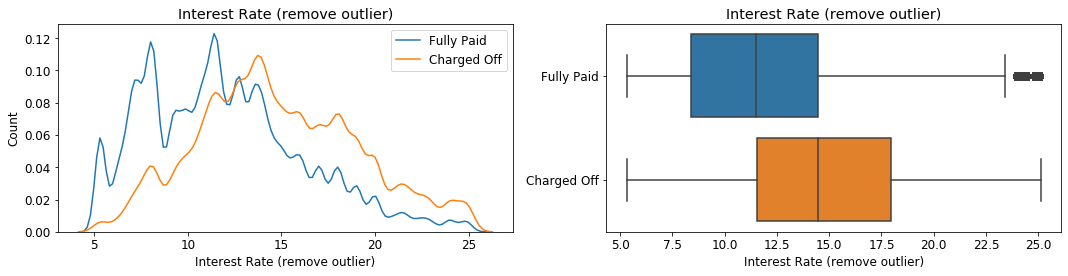

In [39]:
plot_num(df_int_rate, 'int_rate', 'Interest Rate (remove outlier)')

The borrowers who are charged off tend to have higher interest rate

#### 6) `revol_util`
- Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

In [40]:
df['revol_util'].describe()

count    1.154553e+06
mean     4.922737e+01
std      2.472409e+01
min      0.000000e+00
25%      3.030000e+01
50%      4.890000e+01
75%      6.800000e+01
max      1.930000e+02
Name: revol_util, dtype: float64

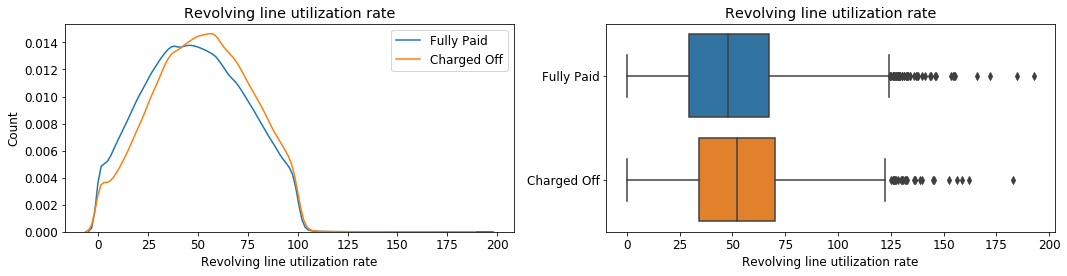

In [41]:
plot_num(df, 'revol_util', 'Revolving line utilization rate')

remove outlier

In [42]:
df_revol_util = df[['revol_util', 'loan_status']].copy()
print(len(df_revol_util))

1154553


In [43]:
df_revol_util = remove_outlier_IQR(df_revol_util, 'revol_util')
print(len(df_revol_util))

1154478


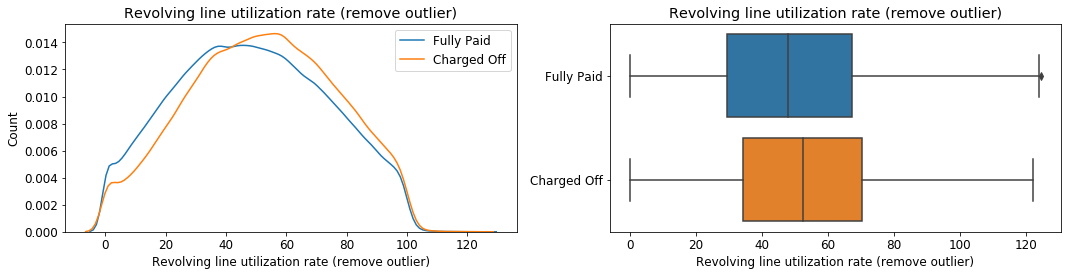

In [44]:
plot_num(df_revol_util, 'revol_util', 'Revolving line utilization rate (remove outlier)')

The borrowers who are charged off tend to have higher revolving line utilization rate

#### 7) `term`
- The number of payments on the loan. Values are in months and can be either 36 or 60.

In [45]:
df['term'].describe()

count        1154553
unique             2
top        36 months
freq          873856
Name: term, dtype: object

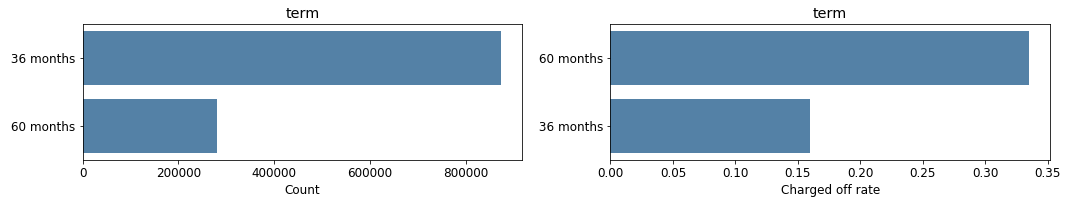

In [46]:
plot_cat(df, 'term', 'term', 3)

In [47]:
df['term'].value_counts()

 36 months    873856
 60 months    280697
Name: term, dtype: int64

#### 8) `grade`
- LC assigned loan grade

In [48]:
df['grade'].describe()

count     1154553
unique          7
top             B
freq       339278
Name: grade, dtype: object

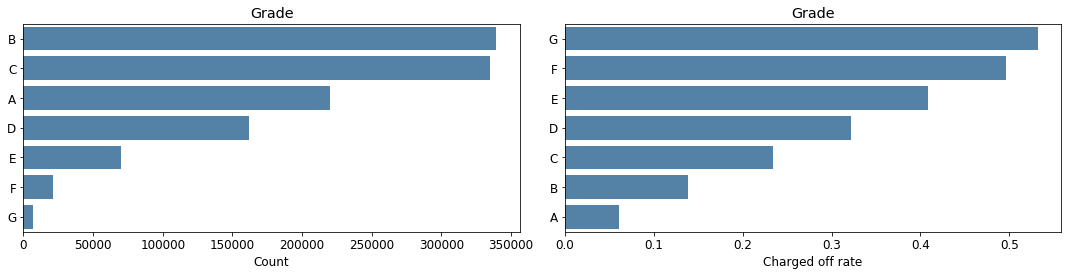

In [49]:
plot_cat(df, 'grade', 'Grade', 4)

#### 9) `emp_length`
- Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

In [50]:
df['emp_length'].describe()

count       1154553
unique           11
top       10+ years
freq         411208
Name: emp_length, dtype: object

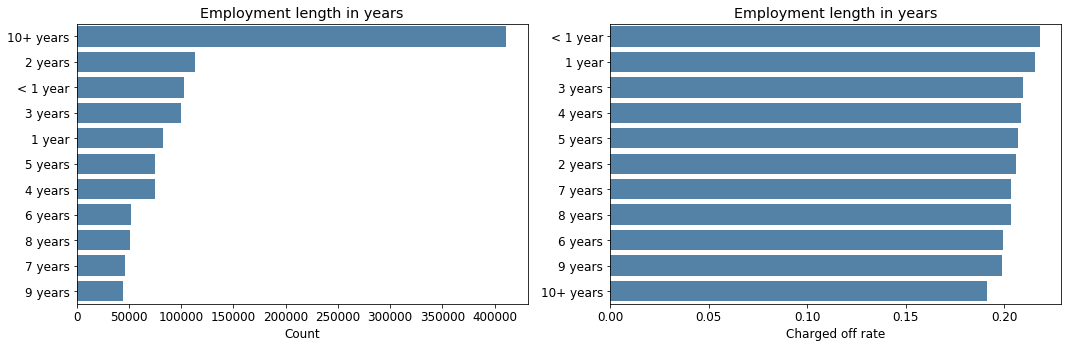

In [51]:
#df.columns#['emp_length'].head()
plot_cat(df, 'emp_length', 'Employment length in years',5)

In [52]:
df['emp_length'].unique()

array(['< 1 year', '6 years', '10+ years', '8 years', '2 years',
       '9 years', '1 year', '5 years', '4 years', '7 years', '3 years'],
      dtype=object)

#### 10) `'home_ownership'`
- The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

In [53]:
df['home_ownership'].describe()

count      1154553
unique           5
top       MORTGAGE
freq        568337
Name: home_ownership, dtype: object

In [54]:
df['home_ownership'].value_counts()

MORTGAGE    568337
RENT        458001
OWN         127429
ANY            784
NONE             2
Name: home_ownership, dtype: int64

In [55]:
# drop NONE
df = df[df['home_ownership']!='NONE']
df['home_ownership'].value_counts()

MORTGAGE    568337
RENT        458001
OWN         127429
ANY            784
Name: home_ownership, dtype: int64

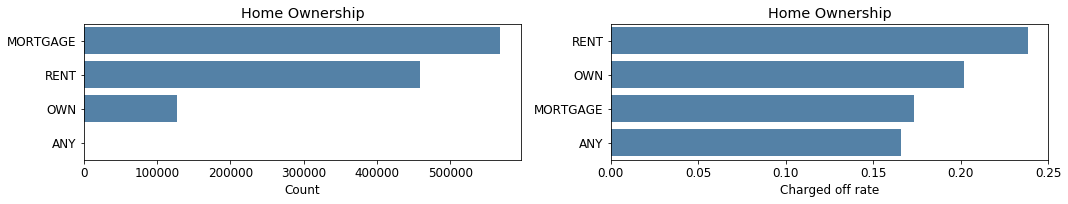

In [56]:
plot_cat(df, 'home_ownership', 'Home Ownership', 3)

#### 11) `verification_status`
- Indicates if income was verified by LC, not verified, or if the income source was verified


In [57]:
df['verification_status'].describe()

count             1154551
unique                  3
top       Source Verified
freq               501776
Name: verification_status, dtype: object

In [58]:
df['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

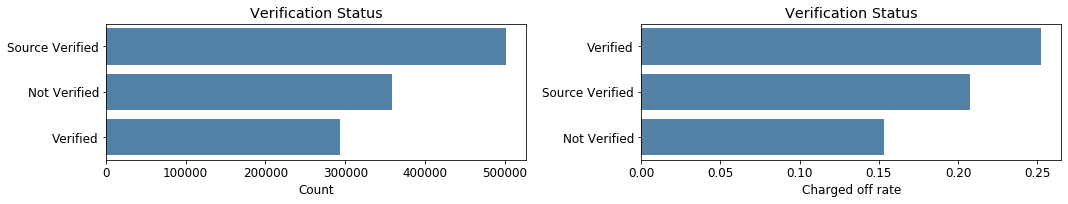

In [59]:
plot_cat(df,'verification_status', 'Verification Status',3)

#### 12) `'purpose'`
- A category provided by the borrower for the loan request.

In [60]:
df['purpose'].describe()

count                1154551
unique                    14
top       debt_consolidation
freq                  660155
Name: purpose, dtype: object

In [61]:
df['purpose'].unique()

array(['credit_card', 'major_purchase', 'debt_consolidation',
       'small_business', 'home_improvement', 'other', 'house', 'medical',
       'car', 'vacation', 'moving', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

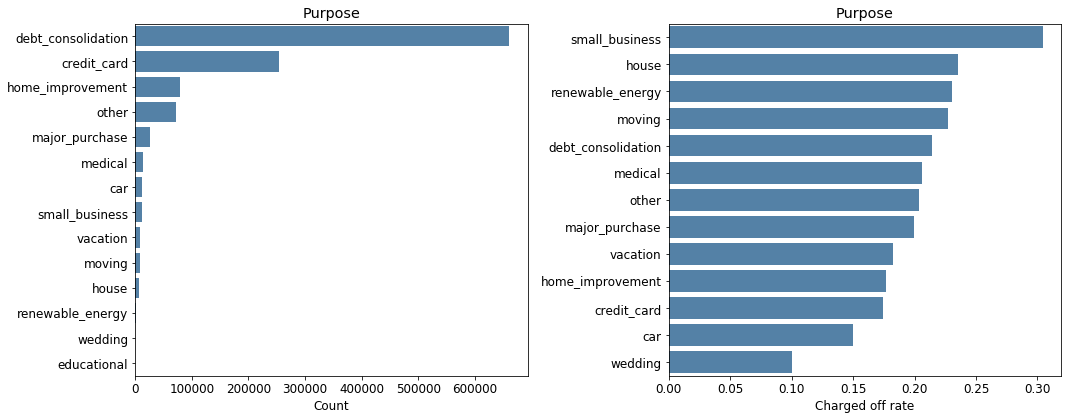

In [62]:
plot_cat(df,'purpose', 'Purpose',6)

#### 13) `addr_state`
- The state provided by the borrower in the loan application

In [63]:
df['addr_state'].describe()

count     1154551
unique         50
top            CA
freq       161641
Name: addr_state, dtype: object

In [64]:
df['addr_state'].unique()

array(['OH', 'PA', 'RI', 'SC', 'NC', 'AZ', 'VA', 'NY', 'KS', 'AL', 'NM',
       'TX', 'MD', 'WA', 'GA', 'LA', 'IL', 'CO', 'FL', 'MI', 'MO', 'IN',
       'WI', 'CA', 'VT', 'TN', 'MA', 'NJ', 'OR', 'SD', 'MN', 'DC', 'DE',
       'NH', 'NE', 'AR', 'NV', 'MT', 'WV', 'HI', 'OK', 'WY', 'KY', 'CT',
       'MS', 'UT', 'ND', 'ME', 'AK', 'ID'], dtype=object)

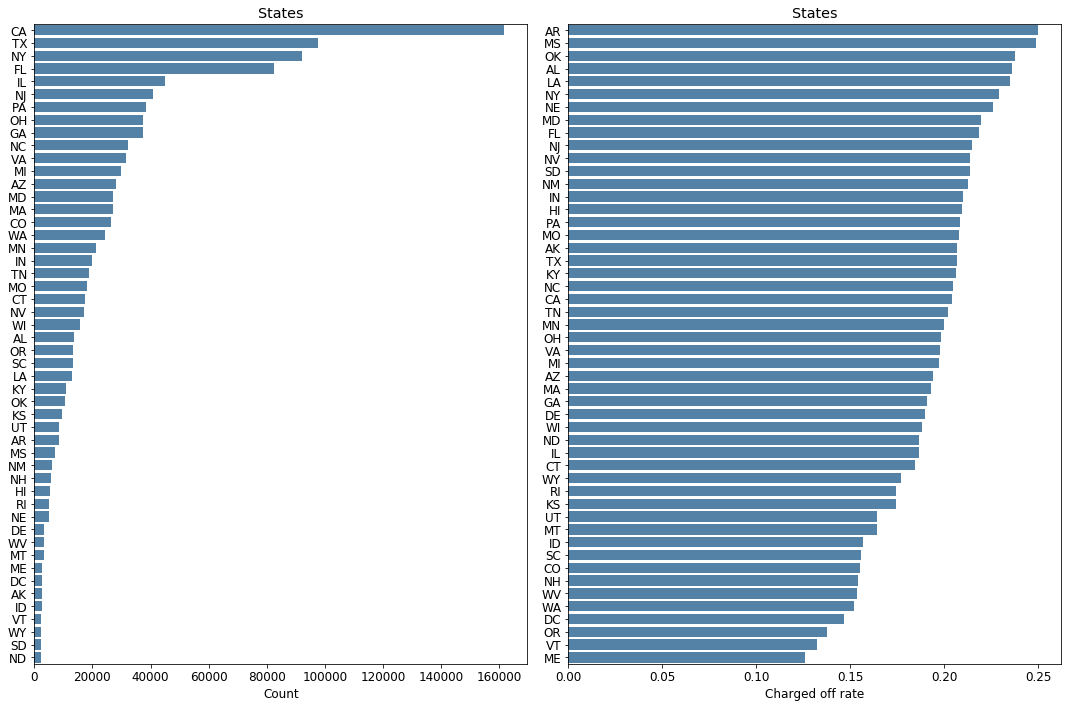

In [65]:
plot_cat(df,'addr_state', 'States',10)

#### 14) `loan_amnt`
- The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value

In [66]:
df['loan_amnt'].describe()

count    1.154551e+06
mean     1.482716e+04
std      9.138443e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.220000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

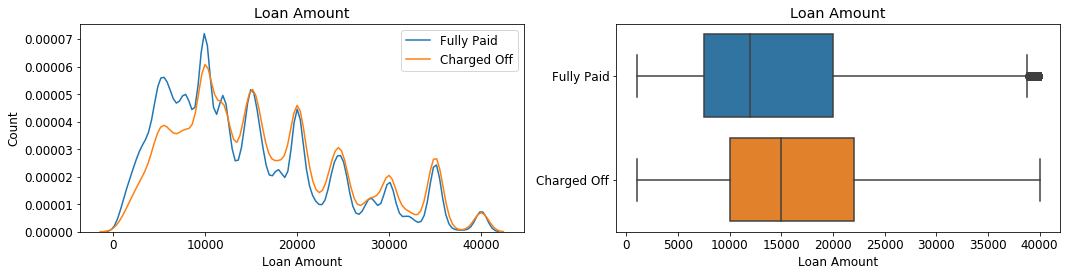

In [67]:
plot_num(df,'loan_amnt', 'Loan Amount')

remove outlier

In [68]:
df_loan_amnt = df[['loan_amnt', 'loan_status']].copy()
print(len(df_loan_amnt))

1154551


In [69]:
df_loan_amnt = remove_outlier_IQR(df_loan_amnt, 'loan_amnt')
print(len(df_loan_amnt))

1139982


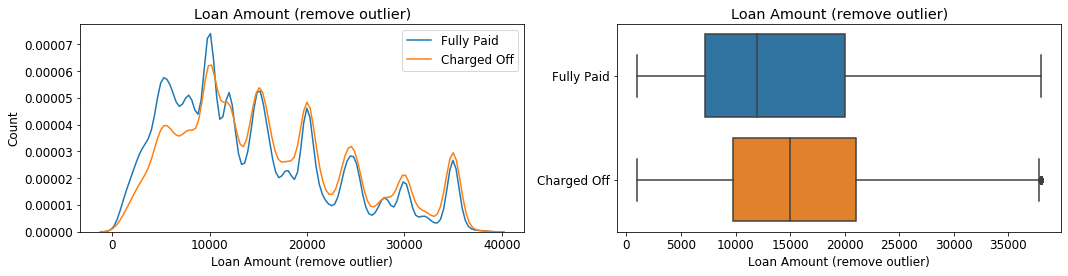

In [70]:
plot_num(df_loan_amnt,'loan_amnt', 'Loan Amount (remove outlier)')

#### 15) `funded_amnt`
- The total amount committed to that loan at that point in time.

In [71]:
df['funded_amnt'].describe()

count    1.154551e+06
mean     1.482715e+04
std      9.138443e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.220000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64

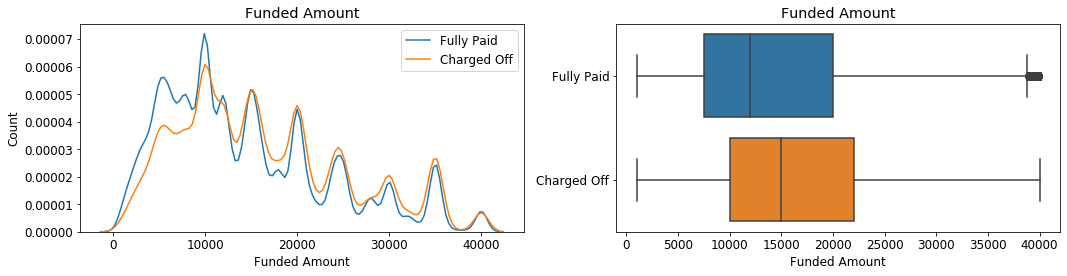

In [72]:
plot_num(df, 'funded_amnt', 'Funded Amount')

In [73]:
df_funded_amnt = df[['funded_amnt', 'loan_status']].copy()
print(len(df_funded_amnt))

1154551


In [74]:
df_funded_amnt = remove_outlier_IQR(df_funded_amnt, 'funded_amnt')
print(len(df_funded_amnt))

1139982


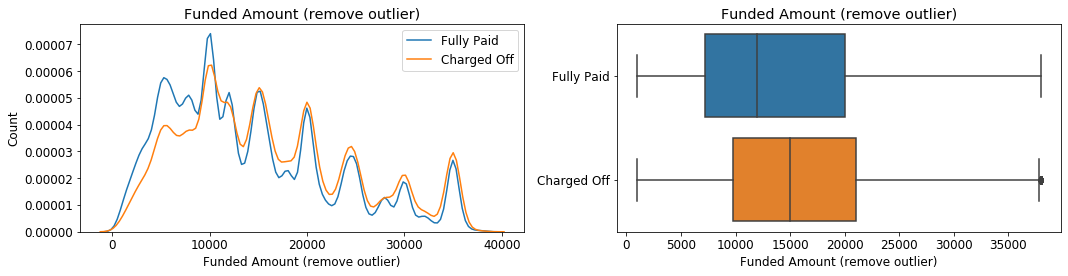

In [75]:
plot_num(df_funded_amnt, 'funded_amnt', 'Funded Amount (remove outlier)')

#### 16) `installment`
- The monthly payment owed by the borrower if the loan originates.

In [76]:
df['installment'].describe()

count    1.154551e+06
mean     4.479892e+02
std      2.739269e+02
min      1.401000e+01
25%      2.487100e+02
50%      3.770400e+02
75%      6.010450e+02
max      1.719830e+03
Name: installment, dtype: float64

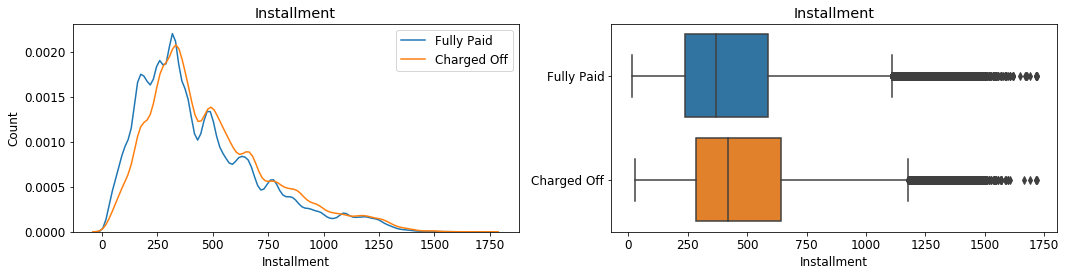

In [77]:
plot_num(df,'installment', 'Installment')

remove outlier

In [81]:
df_installment = df[['installment', 'loan_status']].copy()
print(len(df_installment))

1154551


In [82]:
df_installment = remove_outlier_IQR(df_installment, 'installment')
print(len(df_installment))

1121599


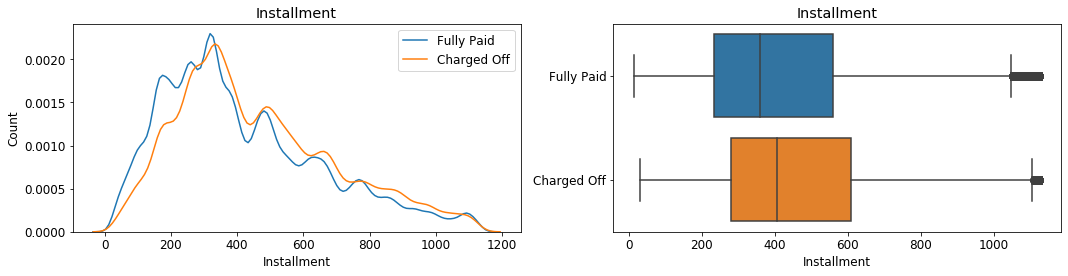

In [83]:
plot_num(df_installment,'installment', 'Installment')

#### 17) `annual_inc`
- The self-reported annual income provided by the borrower during registration.

In [84]:
df['annual_inc'].describe()

count    1.154551e+06
mean     8.046548e+04
std      1.287824e+05
min      0.000000e+00
25%      4.890000e+04
50%      6.800000e+04
75%      9.500000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

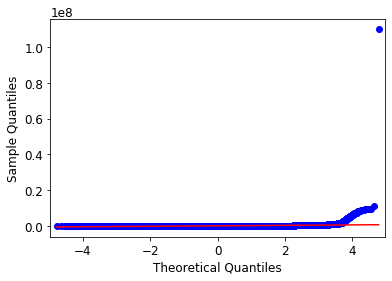

In [85]:
sm.qqplot(df['annual_inc'], line='s')#, line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

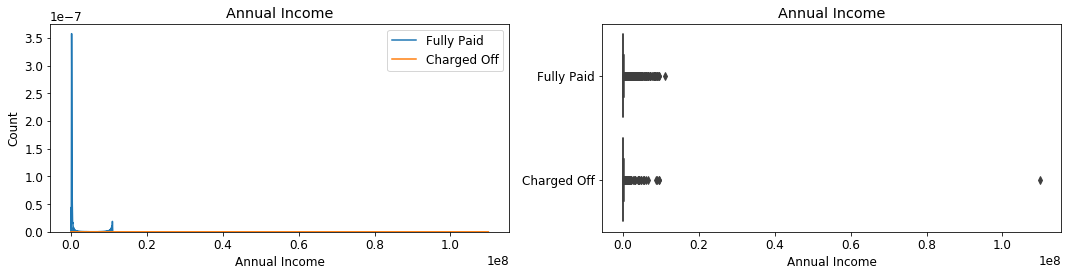

In [86]:
# without log transform
plot_num(df,'annual_inc', 'Annual Income')

Annual income ranges from 0 to 110,000,000, with a median of 68,000. Because of the large range of annual incomes, we can take a log transform of the annual income variable.

In [87]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x))

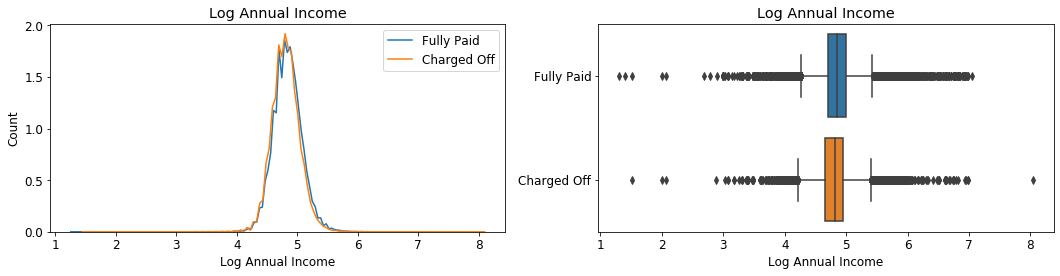

In [88]:
# after log transform
plot_num(df,'log_annual_inc', 'Log Annual Income')

remove outlier

In [89]:
df_log_annual_inc = df[['log_annual_inc', 'loan_status']].copy()
print(len(df_log_annual_inc))

1154551


In [90]:
df_log_annual_inc = remove_outlier_IQR(df_log_annual_inc, 'log_annual_inc')
print(len(df_log_annual_inc))

1134171


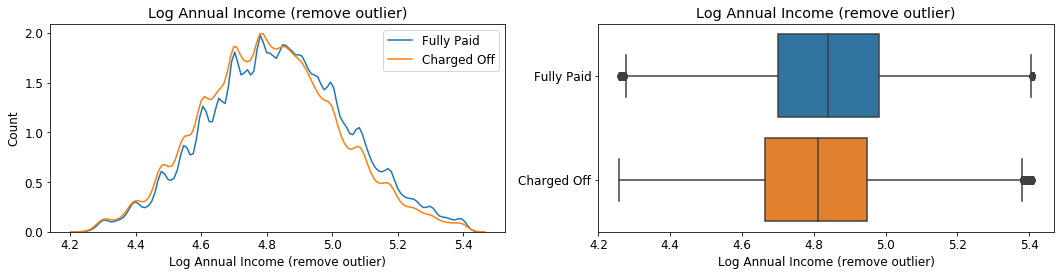

In [91]:
plot_num(df_log_annual_inc ,'log_annual_inc', 'Log Annual Income (remove outlier)')

#### 18) `dti`
- A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

In [92]:
df['dti'].describe()

count    1.154551e+06
mean     1.874129e+01
std      1.136332e+01
min     -1.000000e+00
25%      1.198000e+01
50%      1.794000e+01
75%      2.465000e+01
max      9.990000e+02
Name: dti, dtype: float64

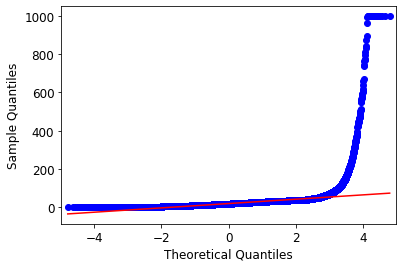

In [93]:
sm.qqplot(df['dti'], line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

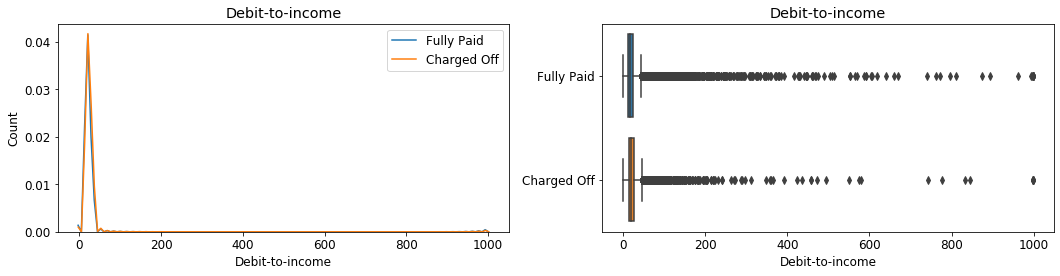

In [94]:
plot_num(df,'dti', 'Debit-to-income')

In [95]:
df['log_dti'] = df['dti'].apply(lambda x: np.log10(x))

In [160]:
# check missing values
df['log_dti'].isnull().sum()

2

In [161]:
#Drop the row where at least one element is missing.
df['log_dti'].dropna(axis=0, inplace=True)

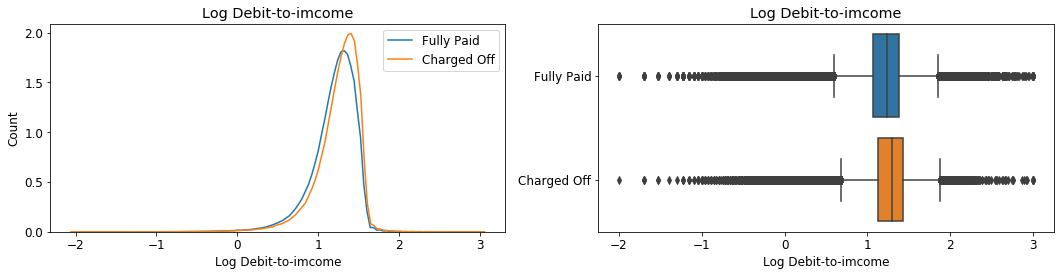

In [168]:
# after log transform
plot_num(df,'log_dti', 'Log Debit-to-imcome')

remove outlier

1154551
1113034


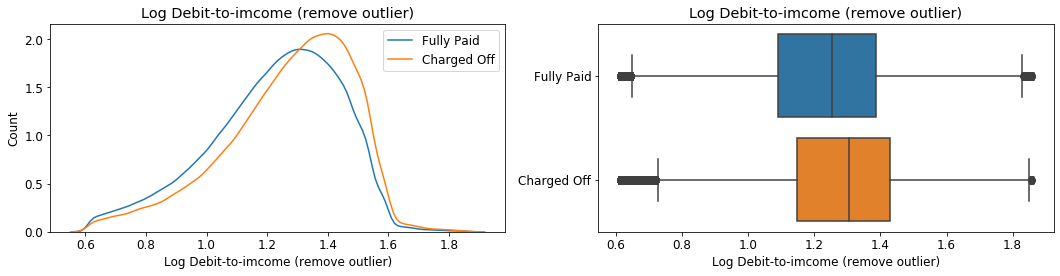

In [169]:
df_log_dti = df[['log_dti', 'loan_status']].copy()
print(len(df_log_dti))

df_log_dti = remove_outlier_IQR(df_log_dti, 'log_dti')
print(len(df_log_dti))

plot_num(df_log_dti ,'log_dti', 'Log Debit-to-imcome (remove outlier)')

#### 19) `revol_bal`
- Total credit revolving balance

In [98]:
df['revol_bal'].describe()

count    1.154551e+06
mean     1.655442e+04
std      2.341443e+04
min      0.000000e+00
25%      5.801000e+03
50%      1.101700e+04
75%      1.978900e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

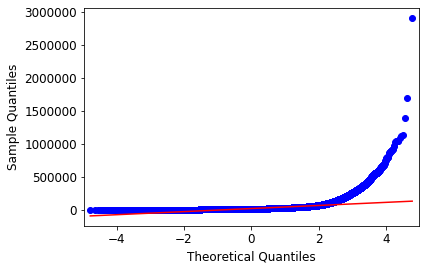

In [99]:
sm.qqplot(df['revol_bal'], line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

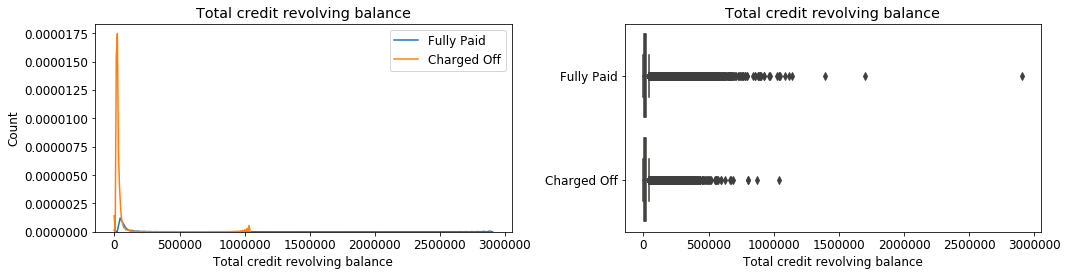

In [100]:
plot_num(df,'revol_bal', 'Total credit revolving balance')

In [101]:
df['log_revol_bal'] = df['revol_bal'].apply(lambda x: np.log10(x))

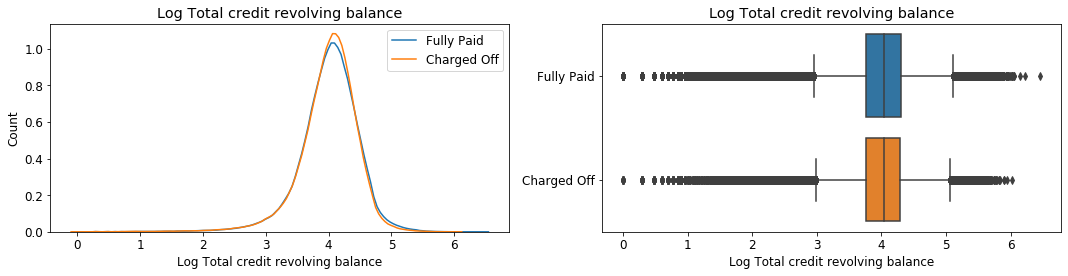

In [102]:
plot_num(df,'log_revol_bal', 'Log Total credit revolving balance')

remove outlier

1154551
1111168


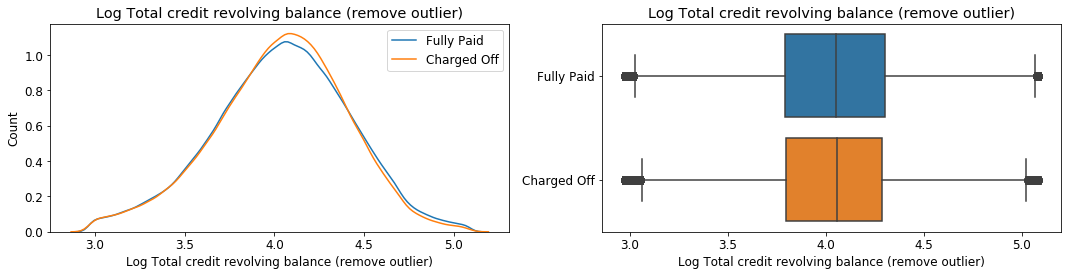

In [103]:
df_log_revol_bal = df[['log_revol_bal', 'loan_status']].copy()
print(len(df_log_revol_bal))

df_log_revol_bal = remove_outlier_IQR(df_log_revol_bal , 'log_revol_bal')
print(len(df_log_revol_bal))

plot_num(df_log_revol_bal ,'log_revol_bal', 'Log Total credit revolving balance (remove outlier)')

####  20) `'delinq_2yrs'`
- The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [104]:
df['delinq_2yrs'].describe()

count    1.154551e+06
mean     3.319836e-01
std      9.139701e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: delinq_2yrs, dtype: float64

In [105]:
df['delinq_2yrs'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  6.,  5., 15.,  7., 10.,  9.,  8., 13.,
       11., 14., 12., 30., 18., 16., 17., 26., 20., 22., 27., 19., 39.,
       21., 29., 42., 25., 28., 36., 23.])

Convert 'deling_2yrs' feature to categorical variable

In [106]:
df['delinq_2yrs_str'] = df['delinq_2yrs'].apply(lambda x: str(int(x)))

In [107]:
df['delinq_2yrs_str'].describe()

count     1154551
unique         33
top             0
freq       925818
Name: delinq_2yrs_str, dtype: object

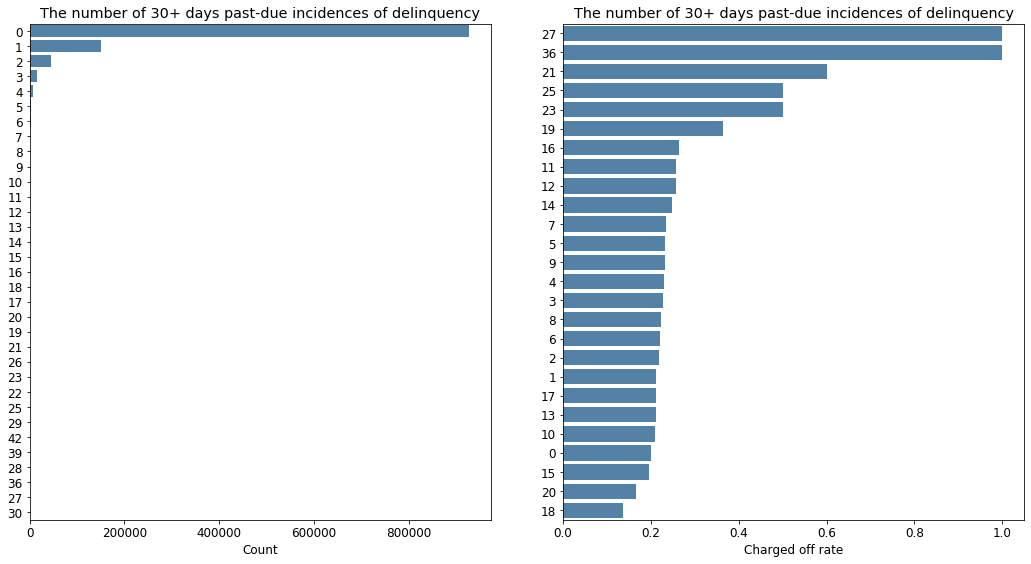

In [108]:
plot_cat(df,'delinq_2yrs_str', 'The number of 30+ days past-due incidences of delinquency',8)

(0, 1000)

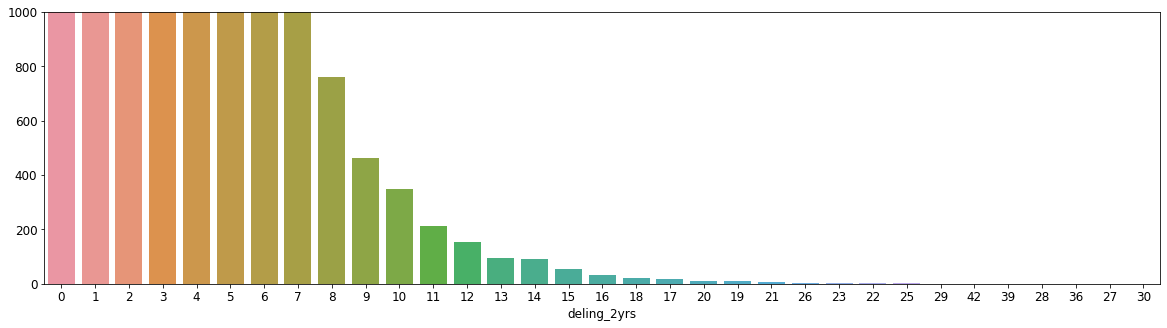

In [109]:

plt.figure(figsize=(20,5))
sns.countplot(x='delinq_2yrs_str', data = df,\
              order = df['delinq_2yrs_str'].value_counts().index)
plt.xlabel('deling_2yrs')
plt.ylabel('Count')
plt.ylabel('')
plt.ylim(0,1000)
#ax1.set_title(full_name)

#### x21) `'open_acc'`
- The number of open credit lines in the borrower's credit file.

In [110]:
df['open_acc'].describe()

count    1.154551e+06
mean     1.186684e+01
std      5.757664e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

In [111]:
df['open_acc'].unique()

array([ 5., 14.,  8., 16.,  7., 17.,  9.,  6., 12., 20., 11., 33., 15.,
       10., 24., 13., 27., 18., 28., 22.,  3.,  4., 29., 19., 25., 21.,
       23., 26., 30., 46., 34., 35.,  2., 32., 40., 55., 37., 39., 31.,
       38., 36., 47., 44.,  1., 42., 41., 43., 52., 45., 53., 65., 51.,
       58., 67., 49., 50., 57., 48., 66., 54., 68., 61., 70., 60., 56.,
       82., 63., 59., 64., 62., 79., 74., 90., 72., 77., 81., 71., 69.,
       80., 86., 88., 76., 84.])

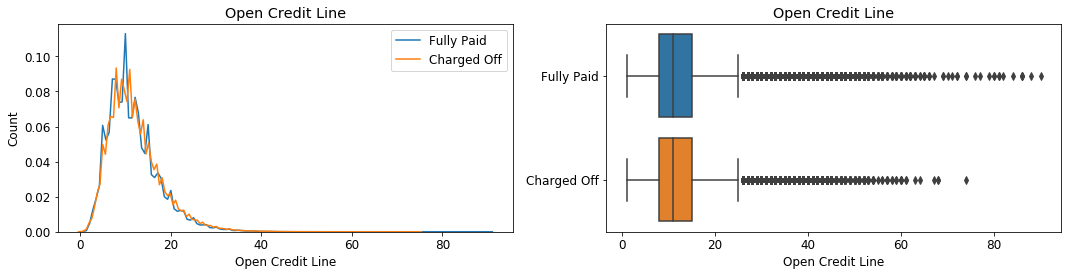

In [111]:
plot_num(df,'open_acc', 'Open Credit Line')

remove outlier

1154551
1122998


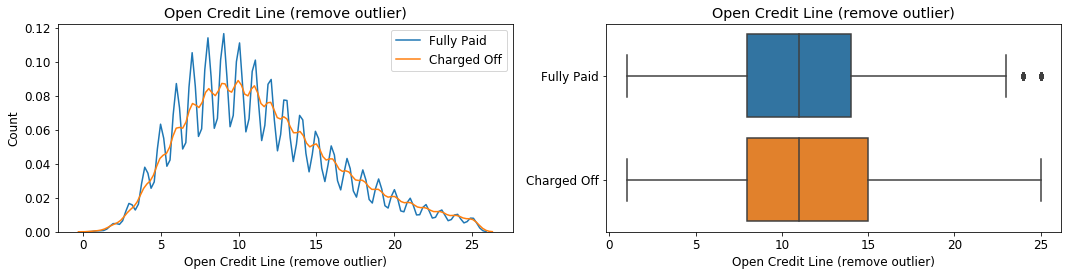

In [112]:
df_open_acc = df[['open_acc', 'loan_status']].copy()
print(len(df_open_acc))

df_open_acc = remove_outlier_IQR(df_open_acc , 'open_acc')
print(len(df_open_acc))

plot_num(df_open_acc ,'open_acc', 'Open Credit Line (remove outlier)')

#### 22) `pub_rec`
- Number of derogatory public records

In [113]:
df['pub_rec'].describe()

count    1.154551e+06
mean     2.254773e-01
std      6.229773e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

In [114]:
df['pub_rec'].unique()

array([ 0.,  1.,  2.,  3.,  5.,  4., 11.,  6.,  7.,  9., 10., 23.,  8.,
       12., 15., 17., 13., 28., 20., 86., 21., 14., 16., 19., 18., 49.,
       22., 46., 37., 31., 47., 24., 45., 25., 61., 32., 44., 52.])

Convert 'pub_rec' feature to categorical variable

In [115]:
df['pub_rec_str']=df['pub_rec'].apply(lambda x: str(int(x)))

In [116]:
df['pub_rec_str'].describe()

count     1154551
unique         38
top             0
freq       951150
Name: pub_rec_str, dtype: object

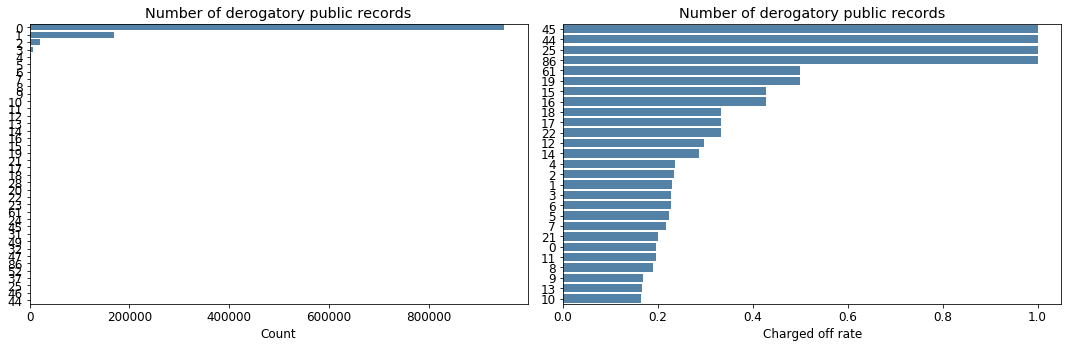

In [117]:
plot_cat(df,'pub_rec_str', 'Number of derogatory public records')

#### 23) 'fico_range_high', 'fico_range_low'

In [118]:
df['fico'] = (df['fico_range_high']  + df['fico_range_high'])/2

In [119]:
df['fico'].describe()

count    1.154551e+06
mean     7.012971e+02
std      3.268952e+01
min      6.640000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.190000e+02
max      8.500000e+02
Name: fico, dtype: float64

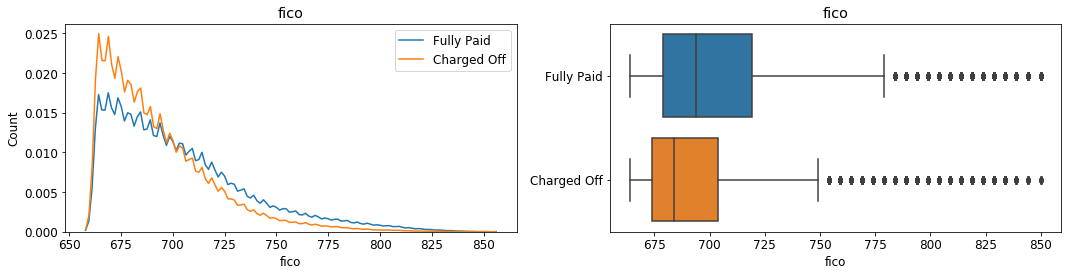

In [120]:
plot_num(df,'fico', 'fico')

remove outlier

1154551
1125171


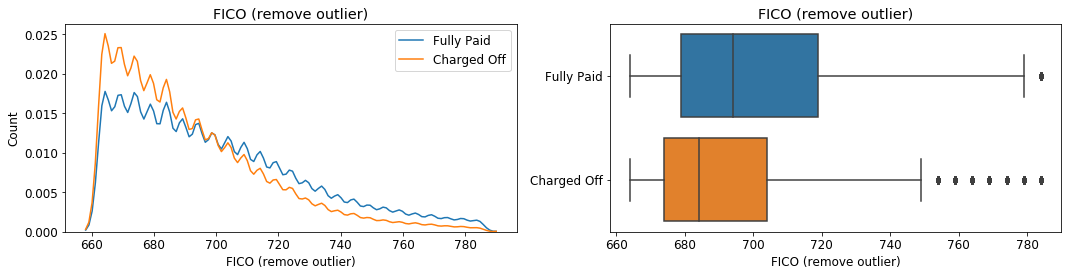

In [121]:
df_fico = df[['fico', 'loan_status']].copy()
print(len(df_fico))

df_fico = remove_outlier_IQR(df_fico , 'fico')
print(len(df_fico))

plot_num(df_fico ,'fico', 'FICO (remove outlier)')

#### 24) `total_pymnt`

In [122]:
df['total_pymnt'].describe()

count    1.154551e+06
mean     1.497938e+04
std      1.053688e+04
min      1.000000e+01
25%      6.788669e+03
50%      1.210180e+04
75%      2.088068e+04
max      6.450823e+04
Name: total_pymnt, dtype: float64

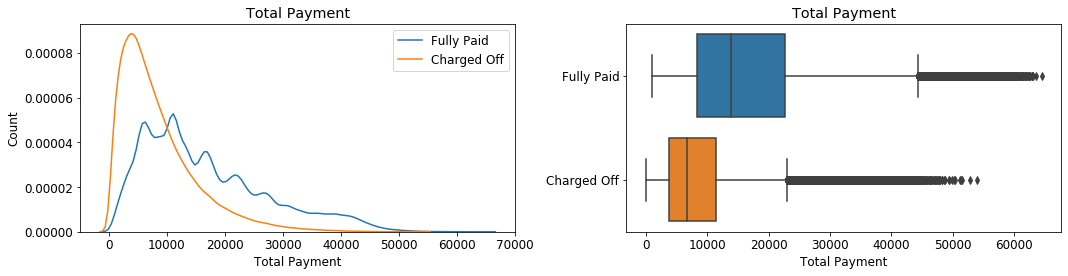

In [123]:
plot_num(df,'total_pymnt', 'Total Payment')

remove outlier

1154551
1130299


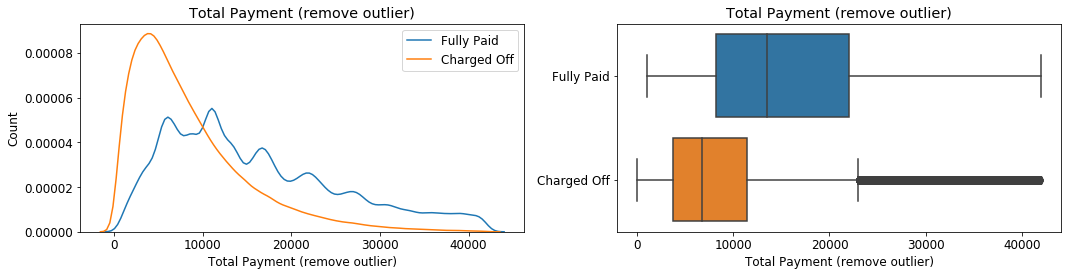

In [124]:
df_total_pymnt = df[['total_pymnt', 'loan_status']].copy()
print(len(df_total_pymnt))

df_total_pymnt = remove_outlier_IQR(df_total_pymnt , 'total_pymnt')
print(len(df_total_pymnt))

plot_num(df_total_pymnt ,'total_pymnt', 'Total Payment (remove outlier)')

#### 25) `recoveries`
- post charge off gross recovery

In [125]:
df['recoveries'].describe()

count    1.154551e+06
mean     2.784021e+02
std      1.060534e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.985955e+04
Name: recoveries, dtype: float64

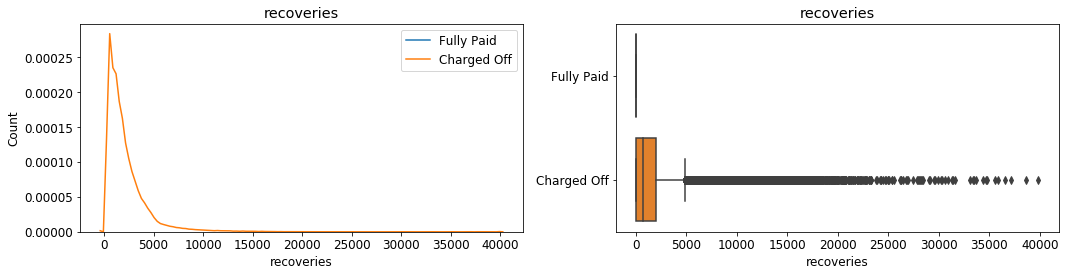

In [126]:
plot_num(df,'recoveries', 'recoveries')

remove outlier

233476
222307


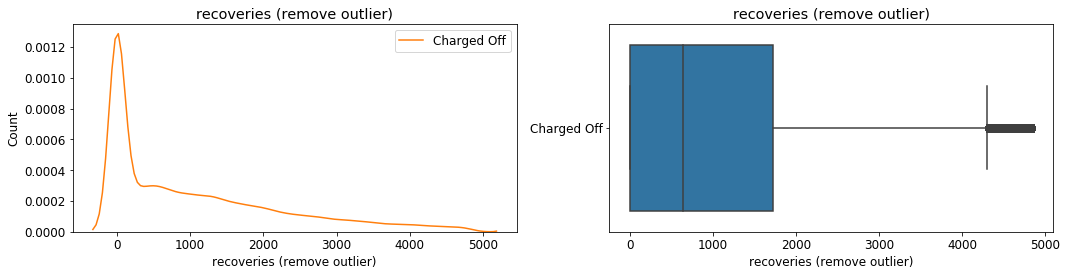

In [128]:
df_recoveries = df[df['loan_status']=='Charged Off'][['recoveries', 'loan_status']].copy()
print(len(df_recoveries))

df_recoveries = remove_outlier_IQR(df_recoveries , 'recoveries')
print(len(df_recoveries))

plot_num(df_recoveries ,'recoveries', 'recoveries (remove outlier)')

borrowers who paid off on time does not have recoveries feature. Remove this feature for ML

### Summary

In [203]:
df.to_csv('LC_preprocessing.csv')

In [170]:
# pick up columns for ML
col_cal = ['term','grade', 'emp_length','home_ownership', 'verification_status', 'purpose', 'addr_state',\
          'delinq_2yrs_str', 'pub_rec']
col_num = ['loan_period','int_rate', 'revol_util','loan_amnt', 'funded_amnt', 'installment','open_acc','fico','total_pymnt',\
          'log_annual_inc', 'log_dti','log_revol_bal']
col_date = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'issue_year']

In [171]:
col_set = col_cal + col_num + col_date
print(col_set)

['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'delinq_2yrs_str', 'pub_rec', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal', 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'issue_year']


In [172]:
print(len(col_set))

25


In [179]:
df_ML = df[col_set].copy()

In [189]:
df_ML.dropna(axis=0, inplace=True)

In [191]:
df_ML.reset_index(drop=True, inplace=True)
df_ML.head()

,term,grade,emp_length,home_ownership,verification_status,purpose,addr_state,delinq_2yrs_str,pub_rec,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,issue_d,earliest_cr_line,last_pymnt_d,issue_year
0,60 months,C,< 1 year,RENT,Source Verified,credit_card,OH,0,0.0,32.000657,13.99,87.4,21000.0,21000.0,488.53,5.0,684.0,27285.807861,4.716003,1.160469,4.309076,2015-12-01,2005-01-01,2018-08-01,2015-01-01
1,36 months,A,6 years,RENT,Not Verified,credit_card,PA,0,1.0,32.000657,6.49,34.5,10000.0,10000.0,306.45,14.0,689.0,10998.971575,4.929419,1.116276,4.019698,2015-12-01,2002-04-01,2018-08-01,2015-01-01
2,36 months,B,10+ years,MORTGAGE,Not Verified,credit_card,RI,0,0.0,16.000329,11.48,39.1,8000.0,8000.0,263.74,8.0,704.0,8939.580503,4.623249,1.541579,3.847202,2015-12-01,1994-11-01,2017-04-01,2015-01-01
3,36 months,B,10+ years,MORTGAGE,Not Verified,major_purchase,SC,1,0.0,13.043389,8.49,5.7,20000.0,20000.0,631.26,8.0,709.0,21538.508977,4.929419,1.245759,2.916980,2015-12-01,1999-02-01,2017-01-01,2015-01-01
4,36 months,A,10+ years,MORTGAGE,Not Verified,debt_consolidation,NC,0,0.0,16.985975,6.49,64.5,28000.0,28000.0,858.05,16.0,724.0,29939.017729,4.963788,1.334454,4.711866,2015-12-01,1984-05-01,2017-05-01,2015-01-01


In [192]:
df_ML.shape

(1154549, 25)

In [193]:
df_ML[col_num].isnull().sum()

loan_period       0
int_rate          0
revol_util        0
loan_amnt         0
funded_amnt       0
installment       0
open_acc          0
fico              0
total_pymnt       0
log_annual_inc    0
log_dti           0
log_revol_bal     0
dtype: int64

In [194]:
df_ML[col_num].head()

,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal
0,32.000657,13.99,87.4,21000.0,21000.0,488.53,5.0,684.0,27285.807861,4.716003,1.160469,4.309076
1,32.000657,6.49,34.5,10000.0,10000.0,306.45,14.0,689.0,10998.971575,4.929419,1.116276,4.019698
2,16.000329,11.48,39.1,8000.0,8000.0,263.74,8.0,704.0,8939.580503,4.623249,1.541579,3.847202
3,13.043389,8.49,5.7,20000.0,20000.0,631.26,8.0,709.0,21538.508977,4.929419,1.245759,2.916980
4,16.985975,6.49,64.5,28000.0,28000.0,858.05,16.0,724.0,29939.017729,4.963788,1.334454,4.711866


In [195]:
for i in col_num:
    print(i)

loan_period
int_rate
revol_util
loan_amnt
funded_amnt
installment
open_acc
fico
total_pymnt
log_annual_inc
log_dti
log_revol_bal


In [138]:
df_ML_LP = remove_outlier_IQR(df_ML, 'loan_period')
df_ML_LP.shape

(1154551, 25)

remove outlier

In [196]:
df_ML_1 = df_ML.copy()

In [197]:
for feature in col_num:
    df_ML_1 = remove_outlier_IQR(df_ML_1, feature)

In [198]:
df_ML_1.shape

(921635, 25)

In [150]:
df_ML.shape

(1154551, 25)

In [200]:
df_ML[col_num].head()

,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal
0,32.000657,13.99,87.4,21000.0,21000.0,488.53,5.0,684.0,27285.807861,4.716003,1.160469,4.309076
1,32.000657,6.49,34.5,10000.0,10000.0,306.45,14.0,689.0,10998.971575,4.929419,1.116276,4.019698
2,16.000329,11.48,39.1,8000.0,8000.0,263.74,8.0,704.0,8939.580503,4.623249,1.541579,3.847202
3,13.043389,8.49,5.7,20000.0,20000.0,631.26,8.0,709.0,21538.508977,4.929419,1.245759,2.916980
4,16.985975,6.49,64.5,28000.0,28000.0,858.05,16.0,724.0,29939.017729,4.963788,1.334454,4.711866


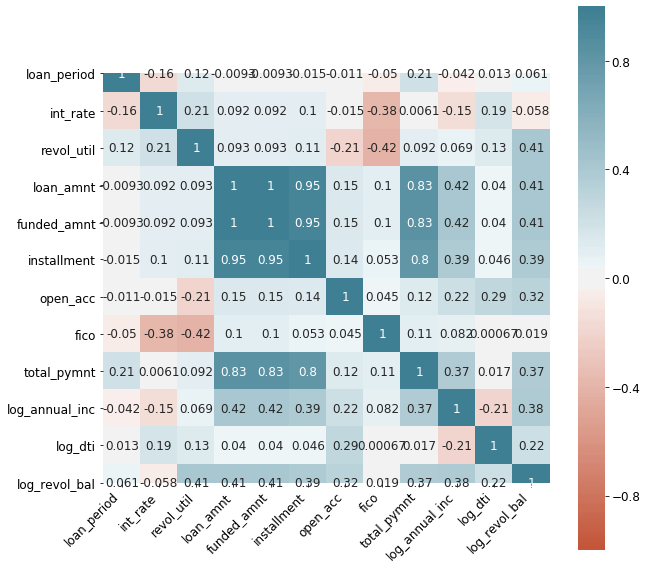

In [201]:
# heatmap

#sns.heatmap(df_ML[col_num].corr(), annot = True,  cbar=True)
#
plt.figure(figsize=(10,10))

ax = sns.heatmap(
    df_ML_1[col_num].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [202]:
df_ML_1.to_csv('LC_ML_prep.csv')